In [105]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer, RobustScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

from models.prepareData import getData, convertData, calcMinimumMaximum
from models.models import linearRegressionModel, PolynomialFeatures, lassoRegressionModel, ridgeRegressionModel
from models.models import RANSACRegressionModel, PolynomialRegressionModel, polynomialRegression

In [106]:
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Thọ', 'Phước Kiển', 'Nhà Bè')
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Cảnh', '22', 'Bình Thạnh')
# data = getData('Bán đất', 'Trần Văn Giàu', 'Lê Minh Xuân', 'Bình Chánh')
# data = getData('Bán đất', 'Vườn Lài', 'An Phú Đông', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán nhà riêng', 'Phạm Văn Chiêu', '9', 'Gò Vấp')
# data = getData('Bán nhà riêng', 'Nguyễn Văn Quá', 'Đông Hưng Thuận', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán đất', 'Nguyễn Thị Rành', 'Nhuận Đức', 'Củ Chi')
# data = getData('Bán đất', 'Tôn Đản', '10', '4')
# data = getData('Bán căn hộ chung cư', '9A', 'Bình Hưng', 'Bình Chánh')
# data = getData('Bán nhà riêng', 'Cao Thắng', '12', '10')
data = getData('Bán đất', 'Bà Thiên', 'Nhuận Đức', 'Củ Chi')
# data = getData('Bán nhà riêng', 'Số 8', 'Linh Xuân', 'Thủ Đức')
# data = getData('Bán đất', 'Bình Mỹ', 'Bình Mỹ', 'Củ Chi')
# data = getData('Bán đất', 'Nguyễn Văn Tạo', 'Long Thới', 'Nhà Bè')
# data = getData('Bán đất', 'Ngô Chí Quốc', 'Bình Chiểu', 'Thủ Đức')

In [107]:
post_type = data['post_type'].iloc[0]
street = data['street'].iloc[0]
ward = data['ward'].iloc[0]
district = data['district'].iloc[0]

In [108]:
print("Data length: ", len(data))

Data length:  187


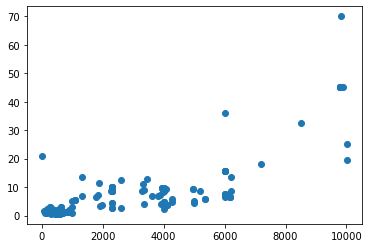

In [109]:
plt.scatter(data['area'], data['price'])
plt.show()

## Feature Engineering

### Clean data by observing dataset:

In [110]:
data = data[~(data['area'] < 10)]
data = data[~(data['price'] > 200)]

In [111]:
area_mean = np.mean(data['area'])
area_std = np.std(data['area'])

price_mean = np.mean(data['price'])
price_std = np.std(data['price'])

data = data[~( (data['area'] < area_mean) & (data['price'] > price_mean+1.5) )]
data = data[~( (data['area'] > area_mean) & (data['price'] < price_mean+1.5) )]

In [112]:
print("Area mean: ", area_mean)
print("Price mean: ", price_mean)

Area mean:  2478.5989247311827
Price mean:  6.828126881720429


In [113]:
print("Data length: ", len(data))

Data length:  142


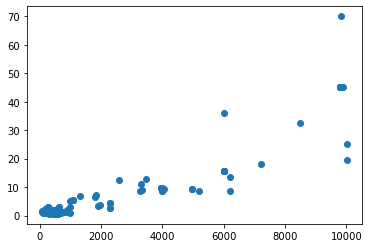

In [114]:
plt.scatter(data['area'], data['price'])
plt.show()

### Feature Scaling (both area & price)

In [115]:
# transform data into log1p
data['area'] = (data['area']).transform(np.log1p)
data['price'] = (data['price']).transform(np.log1p)

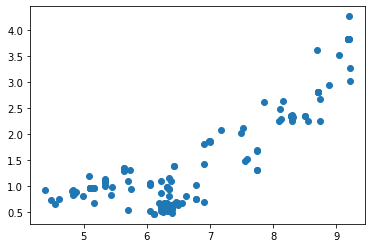

In [116]:
plt.scatter(data['area'], data['price'])
plt.show()

### Calculate mean of duplicated data

In [117]:
# Instead of drop duplicates try calc and use its mean value:
data = data.groupby(['area'], as_index=False).mean()

# sort data by area:
data = data.sort_values(by=['area'])

In [118]:
print("Data length: ", len(data))

Data length:  81


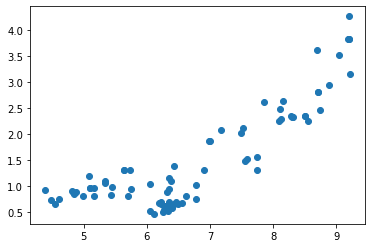

In [119]:
plt.scatter(data['area'], data['price'])
plt.show()

## RANSAC Algorithm in Detecting Outliers
- This method is not a good choice if the dataset not follow linear trends
- Beside, using a base estimator same with the current model will make this prediction in spoiled data => I assume that it is not a good practice

In [120]:
# test_area, test_price = convertData(data)

# # find degree by polynomial regression:
# run_model, model_name, found_degree, rmse = polynomialRegression(test_area, test_price)

# ransac_model = linear_model.RANSACRegressor(base_estimator=PolynomialRegressionModel(degree=found_degree), random_state=0)
# ransac_model.fit(test_area, test_price)

# inlier_mask = ransac_model.inlier_mask_
# outlier_mask = np.logical_not(inlier_mask)

In [121]:
# plt.scatter(data['area'], data['price'], color='blue')
# plt.scatter(test_area[outlier_mask], test_price[outlier_mask], color='red')
# plt.plot(test_area, ransac_model.predict(test_area))
# # run_model.predict(PolynomialFeatures(degree=found_degree).fit_transform(test_area)
# plt.show()

# outlier_indexes = np.where(outlier_mask==True)
# outlier_values = data.iloc[outlier_indexes]
# data = data.drop(outlier_values.index)

### Use IQR method to remove outliers

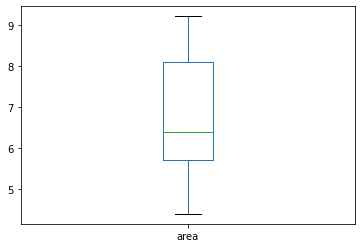

In [122]:
data['area'].plot(kind='box')
plt.show()

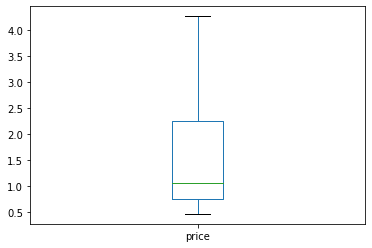

In [123]:
data['price'].plot(kind='box')
plt.show()

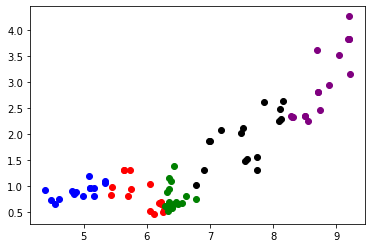

In [124]:
plt.scatter(data['area'][:len(data)//5], data['price'][:len(data)//5], color='blue')
plt.scatter(data['area'][len(data)//5:len(data)*2//5], data['price'][len(data)//5:len(data)*2//5], color='red')
plt.scatter(data['area'][len(data)*2//5:len(data)*3//5], data['price'][len(data)*2//5:len(data)*3//5], color='green')
plt.scatter(data['area'][len(data)*3//5:len(data)*4//5], data['price'][len(data)*3//5:len(data)*4//5], color='black')
plt.scatter(data['area'][len(data)*4//5:], data['price'][len(data)*4//5:], color='purple')
plt.show()

In [125]:
part_data = data['price'][:len(data)//5]
price_minimum, price_maximum = calcMinimumMaximum(part_data)
data_1 = data[:len(data)//5][(part_data > price_minimum) & (part_data < price_maximum)]

part_data = data['price'][len(data)//5:len(data)*2//5]
price_minimum, price_maximum = calcMinimumMaximum(part_data)
data_2 = data[len(data)//5:len(data)*2//5][(part_data > price_minimum) & (part_data < price_maximum)]

part_data = data['price'][len(data)*2//5:len(data)*3//5]
price_minimum, price_maximum = calcMinimumMaximum(part_data)
data_3 = data[len(data)*2//5:len(data)*3//5][(part_data > price_minimum) & (part_data < price_maximum)]

part_data = data['price'][len(data)*3//5:len(data)*4//5]
price_minimum, price_maximum = calcMinimumMaximum(part_data)
data_4 = data[len(data)*3//5:len(data)*4//5][(part_data > price_minimum) & (part_data < price_maximum)]

part_data = data['price'][len(data)*4//5:]
price_minimum, price_maximum = calcMinimumMaximum(part_data)
data_5 = data[len(data)*4//5:][(part_data > price_minimum) & (part_data < price_maximum)]

data = pd.concat([data_1, data_2, data_3, data_4, data_5], ignore_index=True)

In [126]:
print("Data length: ", len(data))

Data length:  59


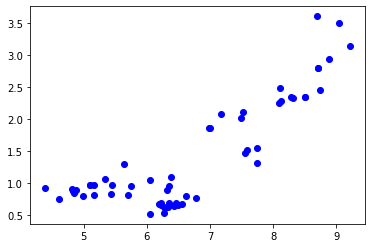

In [127]:
plt.scatter(data['area'], data['price'], color='blue')
plt.show()

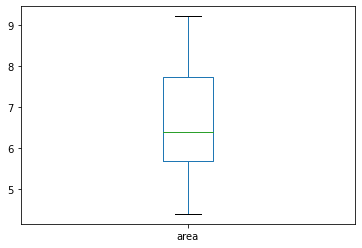

In [128]:
data['area'].plot(kind='box')
plt.show()

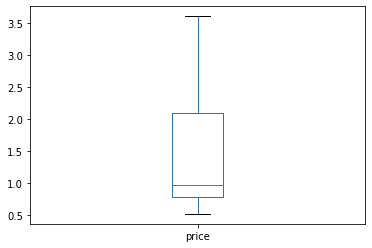

In [129]:
data['price'].plot(kind='box')
plt.show()

In [130]:
max_area = data['area'].max()
max_price = data['price'].max()

### Use Local Outlier Factor to remove _local outliers_

In [131]:
# from sklearn.neighbors import LocalOutlierFactor

# # convert dataframe into numpy array:
# X = data.to_numpy()
# n_neighbors = 8

In [132]:
# isNeighbors = LocalOutlierFactor(n_neighbors=n_neighbors, algorithm='brute', metric='euclidean', contamination=0.2).fit_predict(X)

# # locate outliers by index:
# outlier_indexes = np.where(isNeighbors == -1)
# outlier_values = data.iloc[outlier_indexes]

# # drop outliers:
# data = data.drop(outlier_values.index)

# print("\nOutliers detected by Local Outlier Factor with n_neighbors = ", n_neighbors)
# # plot outliers removed:
# plt.scatter(data['area'], data['price'], color='blue', label='inliers')
# plt.scatter(outlier_values['area'], outlier_values['price'], color='red', label='outliers')
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.tight_layout()
# plt.xlabel('area')
# plt.ylabel('price')
# plt.show()

### Split dataset
1. Train dataset: 70%
2. Validate dataset: 15%
3. Test dataset: 15%

In [133]:
# divide data into train and test:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=4)
test_data, validate_data = train_test_split(test_data, test_size=0.5, random_state=4)

In [134]:
# Sort data by area column:
train_data = train_data.sort_values(by=['area'])
test_data = test_data.sort_values(by=['area'])
validate_data = validate_data.sort_values(by=['area'])

print("\nTrain data length: ", len(train_data))
print("Test data length: ", len(test_data))
print("Validate data length: ", len(validate_data))


Train data length:  41
Test data length:  9
Validate data length:  9


### Visualize features relationship

In [135]:
# # convert data into numpy
X, Y = convertData(data)
X_train, Y_train = convertData(train_data)
X_test, Y_test = convertData(test_data)
X_validate, Y_validate = convertData(validate_data)

Text(0.5, 1.0, 'Y_validate')

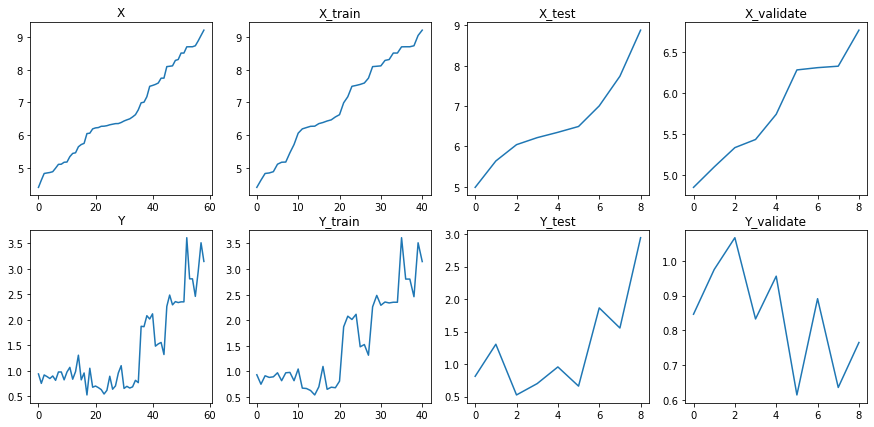

In [136]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0][0].plot(X)
ax[0][0].set_title('X')
ax[0][1].plot(X_train)
ax[0][1].set_title('X_train')
ax[0][2].plot(X_test)
ax[0][2].set_title('X_test')
ax[0][3].plot(X_validate)
ax[0][3].set_title('X_validate')

ax[1][0].plot(Y)
ax[1][0].set_title('Y')
ax[1][1].plot(Y_train)
ax[1][1].set_title('Y_train')
ax[1][2].plot(Y_test)
ax[1][2].set_title('Y_test')
ax[1][3].plot(Y_validate)
ax[1][3].set_title('Y_validate')

## Linear Regression Model

In [137]:
# find model by using linear regression:
linear_regression_model = linearRegressionModel(X_train, Y_train)

# find Y by using linear model predict:
Y_train_pred = linear_regression_model.predict(X_train)
Y_validate_pred = linear_regression_model.predict(X_validate)
Y_test_pred = linear_regression_model.predict(X_test)

# Calculate RMSE on train and test data:
train_linear_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
validate_linear_rmse = np.sqrt(mean_squared_error(Y_validate, Y_validate_pred))
test_linear_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))


Linear Regression Model: 


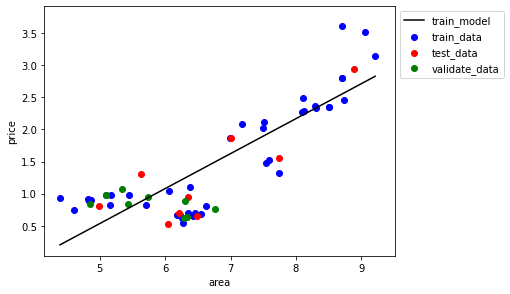

In [138]:
print("\nLinear Regression Model: ")
# Plot linear model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.xlim(right=max_area+0.3)
plt.ylim(top=max_price+0.3)
plt.show()

In [139]:
# Linear Model coefficient and intercept:
print("Linear model coefficient: {}".format(linear_regression_model.coef_))
print("Linear model intercept: {}".format(linear_regression_model.intercept_))

# linear_model rmse:
print("Linear model rmse on train data: {}".format(train_linear_rmse))
print("Linear model rmse on validate data: {}".format(validate_linear_rmse))
print("Linear model rmse on test data: {}".format(test_linear_rmse))
print("\n\n")

Linear model coefficient: [[0.54407529]]
Linear model intercept: [-2.18637322]
Linear model rmse on train data: 0.44954421017697854
Linear model rmse on validate data: 0.454510736495489
Linear model rmse on test data: 0.4444638035824817





In [140]:
def calcRMSE(model, X, Y):
    return np.sqrt(mean_squared_error(Y, model.predict(X)))

def calcCV(model, X, Y, scoring):
    return np.mean(cross_val_score(model, X, Y, scoring=scoring, cv=5))

## Polynomial Regression Model

In [141]:
def polynomialTransform(dataset, degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    dataset_poly = polynomial_features.fit_transform(dataset)
    return dataset_poly

In [142]:
# degree = 2
X_train_poly = polynomialTransform(X_train, 2)
selected_poly_model = linearRegressionModel(X_train_poly, Y_train)

# calc rmse on validate data:
X_validate_poly = polynomialTransform(X_validate, 2)
min_poly_rmse = calcRMSE(selected_poly_model, X_validate_poly, Y_validate)

# Choose model with specific degree:
selected_degree = 2
selected_X_train_poly = X_train_poly

min_degree = 3
max_degree = 100

for i in range(min_degree, max_degree+1):
    X_train_poly = polynomialTransform(X_train, i)
    poly_model = linearRegressionModel(X_train_poly, Y_train)

    # calc rmse on validate data:
    X_validate_poly = polynomialTransform(X_validate, i)
    rmse = calcRMSE(poly_model, X_validate_poly, Y_validate)

    # Try to select the model with minimum rmse:
    if rmse < min_poly_rmse:
        min_poly_rmse = rmse
        selected_poly_model = poly_model
        selected_X_train_poly = X_train_poly
        selected_degree = i
        
print("Polynomial Regression with degree = ", selected_degree)
print("RMSE on validate data: ", min_poly_rmse)
print("Polynomial model coefficient:")
print(selected_poly_model.coef_)
print("Polynomial model intercept: {}\n".format(selected_poly_model.intercept_))

# Predict Y:
Y_train_poly_pred = selected_poly_model.predict(selected_X_train_poly)

Polynomial Regression with degree =  58
RMSE on validate data:  0.15431850069567074
Polynomial model coefficient:
[[-1.47781319e-42 -1.25574084e-42  2.41454170e-43 -2.93814745e-44
   4.15024037e-45  2.70388891e-44  8.13865326e-42 -1.63593631e-42
   2.44320947e-42 -8.60387721e-44  2.46601853e-42 -7.31644043e-44
   3.16569608e-42 -5.55988105e-42  1.19446048e-69  1.29621798e-68
   8.66127052e-68  5.79375881e-67  3.87817200e-66  2.59644188e-65
   1.73780577e-64  1.16217884e-63  7.76184108e-63  5.17416877e-62
   3.44077950e-61  2.28118683e-60  1.50691623e-59  9.91207996e-59
   6.48776157e-58  4.22246971e-57  2.73050477e-56  1.75290391e-55
   1.11611987e-54  7.04137057e-54  4.39644263e-53  2.71321669e-52
   1.65260846e-51  9.91804060e-51  5.85330641e-50  3.38918699e-49
   1.92007222e-48  1.06079120e-47  5.69208126e-47  2.95151126e-46
   1.46944730e-45  6.96551294e-45  3.10842805e-44  1.28551137e-43
   4.81412099e-43  1.57416688e-42  4.21640480e-42  8.07800839e-42
   6.97728086e-42 -7.1991278

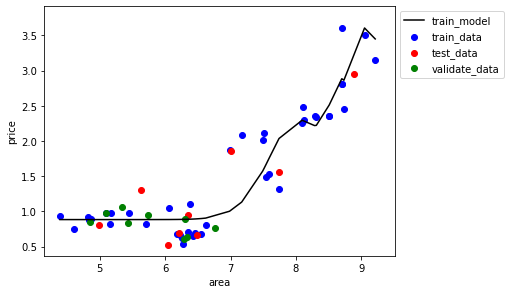

In [143]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_poly_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.xlim(right=max_area+0.3)
plt.ylim(top=max_price+0.3)
plt.show()

### Alpha Hyperparameter

In [144]:
alphas = [0.00001, 0.00003, 0.00005, 0.00008, 0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.1, 1.0, 3.0, 5.0, 10.0, 50.0, 100.0]

In [145]:
X_validate_poly = polynomialTransform(X_validate, selected_degree)

In [146]:
# ignore warnings: =))) 
import warnings

## Ridge Regression Model

In [147]:
selected_ridge_alpha = alphas[0]
warnings.filterwarnings('ignore')

ridge_model = linear_model.Ridge(alpha=selected_ridge_alpha, fit_intercept=True, normalize=False, max_iter=2000, tol=0.001)
min_ridge_cv_score = calcCV(ridge_model, selected_X_train_poly, Y_train, 'r2')

for alpha in alphas[1:]:
    ridge_model = linear_model.Ridge(alpha=alpha, fit_intercept=True, normalize=False, max_iter=2000, tol=0.001)
    ridge_cv_score = calcCV(ridge_model, selected_X_train_poly, Y_train, 'r2')

    if ridge_cv_score > min_ridge_cv_score:
        min_ridge_cv_score = ridge_cv_score
        selected_ridge_alpha = alpha
        
# fit model with selected alpha:
ridge_model = ridgeRegressionModel(selected_X_train_poly, Y_train, selected_ridge_alpha)

# RMSE:
ridge_rmse = calcRMSE(ridge_model, X_validate_poly, Y_validate)

print("Ridge Regression with alpha = {} and RMSE = {}".format(selected_ridge_alpha, ridge_rmse))
print("Ridge Regression coefficient:")
print(ridge_model.coef_)
print("Ridge Regression intercept: ", ridge_model.intercept_)

# Predict Y with Ridge:
Y_train_ridge_pred = ridge_model.predict(selected_X_train_poly)

Ridge Regression with alpha = 1e-05 and RMSE = 0.382599162786933
Ridge Regression coefficient:
[[ 0.00000000e+00  1.74569114e-97  2.38535523e-96  2.45665002e-95
   2.26158777e-94  1.96374047e-93  1.64730148e-92  1.35215146e-91
   1.09424392e-90  8.77205350e-90  6.98777803e-89  5.54288221e-88
   4.38436391e-87  3.46153148e-86  2.72959136e-85  2.15066225e-84
   1.69354954e-83  1.33299456e-82  1.04876684e-81  8.24777025e-81
   6.48286387e-80  5.09236530e-79  3.99697547e-78  3.13422041e-77
   2.45488948e-76  1.92021224e-75  1.49963150e-74  1.16905138e-73
   9.09461093e-73  7.05854457e-72  5.46381344e-71  4.21680994e-70
   3.24357727e-69  2.48568235e-68  1.89696349e-67  1.44096473e-66
   1.08890971e-65  8.18100024e-65  6.10648124e-64  4.52474031e-63
   3.32510532e-62  2.42073185e-61  1.74360843e-60  1.24059564e-59
   8.70285359e-59  6.00510783e-58  4.06373085e-57  2.68678503e-56
   1.72701433e-55  1.07206541e-54  6.36766136e-54  3.57037882e-53
   1.85104629e-52  8.57305347e-52  3.32725461e-

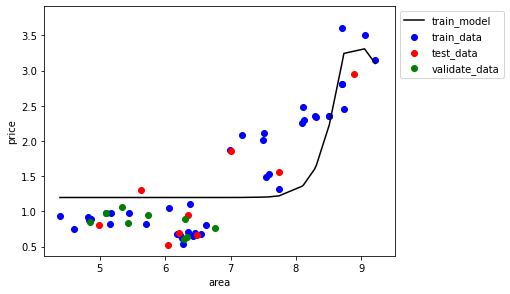

In [148]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_ridge_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.xlim(right=max_area+0.3)
plt.ylim(top=max_price+0.3)
plt.show()

## Lasso Regression Model

In [149]:
selected_lasso_alpha = alphas[0]
warnings.filterwarnings('ignore')

lasso_model = linear_model.Lasso(alpha=selected_lasso_alpha, fit_intercept=True, normalize=True, max_iter=2000, tol=0.001)
min_lasso_cv_score = calcCV(lasso_model, selected_X_train_poly, Y_train, 'r2')

for alpha in alphas[1:]:
    lasso_model = linear_model.Lasso(alpha=alpha, fit_intercept=True, normalize=True, max_iter=2000, tol=0.001)
    lasso_cv_score = calcCV(lasso_model, selected_X_train_poly, Y_train, 'r2')
#     neg_root_mean_squared_error

    if lasso_cv_score > min_lasso_cv_score:
        min_lasso_cv_score = lasso_cv_score
        selected_lasso_alpha = alpha
        
# Fit model with selected alpha:
lasso_model = lassoRegressionModel(selected_X_train_poly, Y_train, selected_lasso_alpha)
lasso_rmse = calcRMSE(lasso_model, X_validate_poly, Y_validate)

print("Lasso Model with alpha = {} and RMSE = {}".format(selected_lasso_alpha, lasso_rmse))
print("Lasso Regression coefficient:")
print(lasso_model.coef_)
print("Lasso Regression intercept: ", lasso_model.intercept_)

# Predict Y with Ridge:
Y_train_lasso_pred = lasso_model.predict(selected_X_train_poly)

Lasso Model with alpha = 0.06 and RMSE = 0.22432199088603683
Lasso Regression coefficient:
[ 0.00000000e+00 -0.00000000e+00 -5.59361457e-02 -9.89207301e-03
  1.26550939e-03  1.03622817e-04  6.16790101e-06  2.68019950e-07
 -2.08936060e-09 -2.46331609e-09 -4.07334811e-10 -5.07003184e-11
 -5.51387473e-12 -5.48339175e-13 -5.06476886e-14 -4.34409730e-15
 -3.40211729e-16 -2.31108985e-17 -1.13331717e-18  7.91548314e-21
  1.28405147e-20  2.44791849e-21  3.54493961e-22  4.55568610e-23
  5.46590448e-24  6.26540566e-25  6.94708738e-26  7.50610059e-27
  7.93915687e-28  8.24396552e-29  8.41878523e-30  8.46207319e-31
  8.37221538e-32  8.14732220e-33  7.78507606e-34  7.28261900e-35
  6.63647041e-36  5.84246684e-37  4.89571725e-38  3.79056854e-39
  2.52057734e-40  1.07848480e-41 -5.43807918e-43 -2.35526525e-43
 -4.36574541e-44 -6.58603198e-45 -9.02786978e-46 -1.17040055e-46
 -1.46282336e-47 -1.78154477e-48 -2.12816977e-49 -2.50442532e-50
 -2.91216729e-51 -3.35338807e-52 -3.83022486e-53 -4.34496865e-54

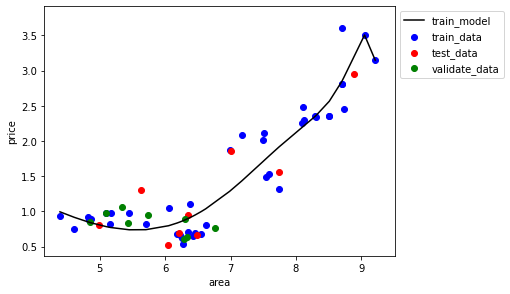

In [150]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_lasso_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.xlim(right=max_area+0.3)
plt.ylim(top=max_price+0.3)
plt.show()

In [151]:
# score the model with test data:
X_test_poly = polynomialTransform(X_test, selected_degree)

# Linear score:
print("\n")

linear_train_r2_score = linear_regression_model.score(X_train, Y_train)
print("Linear Model score on train dataset: ", linear_train_r2_score)

linear_test_r2_score = linear_regression_model.score(X_test, Y_test)
print("Linear Model score on test dataset: ", linear_test_r2_score)

# Poly score:
print("\n")

poly_train_r2_score = selected_poly_model.score(selected_X_train_poly, Y_train)
print("Poly Model score on train dataset: ", poly_train_r2_score)

poly_test_r2_score = selected_poly_model.score(X_test_poly, Y_test)
print("Poly Model score on test dataset: ", poly_test_r2_score)

# Ridge score:
print("\n")

ridge_train_r2_score = ridge_model.score(selected_X_train_poly, Y_train)
print("Ridge Model score on train dataset: ", ridge_train_r2_score)

ridge_test_r2_score = ridge_model.score(X_test_poly, Y_test)
print("Ridge Model score on test dataset: ", ridge_test_r2_score)

# Lasso score:
print("\n")

lasso_train_r2_score = lasso_model.score(selected_X_train_poly, Y_train)
print("Lasso Model score on train dataset: ", lasso_train_r2_score)

lasso_test_r2_score = lasso_model.score(X_test_poly, Y_test)
print("Lasso Model score on test dataset: ", lasso_test_r2_score)



Linear Model score on train dataset:  0.7395760627146284
Linear Model score on test dataset:  0.6297450673457855


Poly Model score on train dataset:  0.8672085244169169
Poly Model score on test dataset:  0.661250955395728


Ridge Model score on train dataset:  0.6381540458309051
Ridge Model score on test dataset:  0.49786180312324424


Lasso Model score on train dataset:  0.8955290686263574
Lasso Model score on test dataset:  0.7844088611383426


In [152]:
# # calc cross validation score of linear to compare with poly for best model selection
# linear_cv = np.mean(cross_val_score(linear_model, X, Y, cv=5))
# poly_cv = np.mean(cross_val_score(poly_model, X, Y, cv=5))

# best_r2_score = linear_test_r2_score if linear_test_r2_score > poly_test_r2_score else poly_test_r2_score
# best_model = linear_model if linear_cv > poly_cv else poly_model
# best_degree = 1 if linear_cv > poly_cv else degree

# print(linear_cv)
# print(poly_cv)

In [153]:
import unidecode
post_type = unidecode.unidecode(post_type.lower().replace(" ", ""))
street = unidecode.unidecode(street.lower().replace(" ", ""))
ward = unidecode.unidecode(ward.lower().replace(" ", ""))
district = unidecode.unidecode(district.lower().replace(" ", ""))
model_name = post_type + "_" + street + "_" + ward + "_" + district

In [154]:
model_name

'bandat_bathien_nhuanduc_cuchi'

In [155]:
# # Save model after training for later use:
# from joblib import dump, load

# if best_r2_score > 0.7:
#     # Save model:
#     dump((best_model, best_degree), 'trained\\' + model_name + '.joblib')

In [156]:
# try:    
#     # load model:
#     loaded_model, loaded_degree = load('trained/' + model_name + ".joblib")

#     test_area = np.array([92.00])
#     test_area = test_area[:, np.newaxis]
#     test_area = FunctionTransformer(np.log1p).fit_transform(test_area)

#     if loaded_degree == 1:
#         predicted_price = loaded_model.predict(test_area)
#     else:
#         test_area_poly = PolynomialFeatures(degree=loaded_degree).fit_transform(test_area)
#         predicted_price = loaded_model.predict(test_area_poly)

#     print(FunctionTransformer(np.log1p).inverse_transform(predicted_price))
# except FileNotFoundError:
#     print("Model not found or trained result is low!")